# Can we predict tomorrow's electricity price? Random Forest Model

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

In [4]:
# Import data
df = pd.read_csv('../data/df_clean.csv', index_col=0, parse_dates=True)

# Copy actual price to new series
tomorrow = df['price actual'].copy()

# Shift the actual price index by a single day backwards
tomorrow = tomorrow.shift(-1, freq='D')

# Copy the df and merge tomorrows price into each row

df = df.join(tomorrow, how='inner', rsuffix='_tomorrow')
df.rename(columns={'price actual_tomorrow':'price tomorrow'}, inplace=True)

## LabelEncode Categoricals

In [6]:
# Get Categorical columns
categorical = df.select_dtypes(include='object')

# Instationate LabelEncoder, fit and transform on wind_direction cols
wind_dir_coder = LabelEncoder()
wind_dir_coder.fit(df['wind_madrid'])
for col in categorical.filter(regex='wind').columns:
    df[col] = wind_dir_coder.transform(df[col])
    

# Stack condition columns into single col
stacked_conditions = categorical.filter(regex='condition').stack()

# Instantiate Label encoder, fit and transform on condition cols
condition_coder = LabelEncoder()
condition_coder.fit(stacked_conditions)
for col in categorical.filter(regex='condition').columns:
    df[col] = condition_coder.transform(df[col])

## Random Forrest with Weather

In [7]:
X = df.drop(columns = 'price tomorrow').copy()
y = df['price tomorrow'].copy()

In [8]:
# Fit RF model
def fit_train(x, y):
    rf = RandomForestRegressor()
    if len(x.shape)==1:
        x = x.to_numpy().reshape(-1,1)
    rf.fit(x,y)
    preds = rf.predict(x)
    results = pd.DataFrame({'pred':preds, 'true':y})
    print('r2: ',(results.corr()**2).iloc[0,1])
    return rf

### rf_1

In [9]:
# Train model and show results
rf_1 = fit_train(X, y)

r2:  0.9950354727195664


In [10]:
# See feature importances
results = pd.DataFrame({'features':X.columns, 'importance':rf_1.feature_importances_})
results.sort_values(by='importance', ascending=False).head()

,features,importance
19,price actual,0.897426
18,price day ahead,0.017517
4,generation fossil oil,0.004244
3,generation fossil hard coal,0.004031
8,generation nuclear,0.003406


<u>Notes</u>: R2 is very high actually. Seems as though price of the day before is by far the most important feature. Since price tomorrow is just price actual shifted by one day, lets remove it and see if the model still performs okay.
### rf_2

In [11]:
# Split data and target
X = df.drop(columns = ['price tomorrow', 'price actual'])
rf_2 = fit_train(X, y)

r2:  0.9917164708726728


In [12]:
# See feature importances
results = pd.DataFrame({'features':X.columns, 'importance':rf_2.feature_importances_})
results.sort_values(by='importance', ascending=False).head()

,features,importance
18,price day ahead,0.647819
4,generation fossil oil,0.032270
52,dew_point_bilbao,0.030682
8,generation nuclear,0.024915
12,generation waste,0.015906


<u>Notes</u>: The model still performed very well even without `price actual` which is great. Now `price day ahead` is clearly the most important feature which makes sense as it's the forecast for tomorrows price.  Is it possible that our other variables aren't even helping that much? Let's check by running a model with the `price day ahead` as the only variable and see how well the model can predict price.
#### rf_3

In [13]:
# Split data and target
X = df.loc[:,'price day ahead']

rf_3 = fit_train(X, y)

r2:  0.7999555209566865


<u>Notes</u>: The model r2 decreased about .2, meaning that the other variables were actually important in predicting the price for tomorrow.  Up to this point, I have not split the data into testing and training.  Let's do that next and see if the model can generalize to unseen data.  I'll split out one continous year's worth of data and try to predict the missing year.  For the predictors, I'll continue to use all columns except for the `price actual` column.
#### rf_4

In [14]:
df.drop(columns='price actual', inplace=True)

In [30]:
# Fit RF model
def fit_train(x_train, x_test, y_train, y_test):
    rf = RandomForestRegressor(random_state=17)
    if len(x_train.shape)==1:
        x_train = x_train.to_numpy().reshape(-1,1)
        x_test = x_test.to_numpy().reshape(-1,1)
    rf.fit(x_train,y_train)
    preds_train = rf.predict(x_train)
    preds_test = rf.predict(x_test)
    results_train = pd.DataFrame({'pred':preds_train, 'true':y_train})
    results_test = pd.DataFrame({'pred':preds_test, 'true':y_test})
    print('r2_train: ',(results_train.corr()**2).iloc[0,1])
    print('r2_test: ',(results_test.corr()**2).iloc[0,1])
    return rf

In [32]:
# Split data and target
X_train = df.loc['2015':'2020'].drop(columns=['price day ahead', 'price tomorrow'])
X_test  = df.loc['2021'].drop(columns=['price day ahead', 'price tomorrow'])

y_train = df.loc['2015':'2020','price tomorrow']
y_test = df.loc['2021','price tomorrow']

rf_4 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9884514484125445
r2_test:  0.10617790044691287


In [33]:
# See feature importances
results = pd.DataFrame({'features':X_train.columns, 'importance':rf_4.feature_importances_})
results.sort_values(by='importance', ascending=False).head(60)

,features,importance
3,generation fossil hard coal,0.385432
8,generation nuclear,0.036923
2,generation fossil gas,0.033663
21,consumption_scheduled,0.032351
4,generation fossil oil,0.031328
6,generation hydro run-of-river and poundage,0.031287
12,generation waste,0.025705
10,generation other renewable,0.025191
55,pressures_bilbao,0.023948
0,generation biomass,0.022387


<u>Notes</u>: The model r2 is very very high on the training set but low on the test set (as expected). Let's remove all features except `price day ahead` to make sure the other features are important.
#### rf_5

In [19]:
# Split data and target
X_train = df.loc['2015':'2020', 'price day ahead']
X_test  = df.loc['2021', 'price day ahead']

y_train = df.loc['2015':'2020','price tomorrow']
y_test = df.loc['2021','price tomorrow']

rf_5 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.5579448712161466
r2_test:  0.26694719035626274


<u>Notes</u>: Model r2 decreased substaintially on the training and testing set, which was to be expected since we only used `price day ahead` in this model. Next let's split the data randomly instead of testing on a continuous year.
## Predict with Random Split (all cols)

In [44]:
# train test split the data and rerun 
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['price day ahead', 'price tomorrow']), 
                                                    df['price tomorrow'],
                                                    test_size=1/7, 
                                                    random_state=17)

rf_6 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9909976728513216
r2_test:  0.9280663631233073


<u>Notes</u>: Model r2 is very good.  Let's try again but only use `price day ahead`. 
## Predict with Random Split (`price day ahead`) only

In [21]:
# train test split the data and rerun 
X_train, X_test, y_train, y_test = train_test_split(df['price day ahead'], 
                                                    df['price tomorrow'],
                                                    test_size=.25, 
                                                    random_state=17)

rf_7 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.8106322027798395
r2_test:  0.594471716008973


## Predict 2015

In [35]:
# Split data and target
X_train = df.loc['2016':'2021'].drop(columns=['price day ahead', 'price tomorrow'])
X_test  = df.loc['2015'].drop(columns=['price day ahead', 'price tomorrow'])

y_train = df.loc['2016':'2021','price tomorrow']
y_test = df.loc['2015','price tomorrow']

rf_8 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9924572688732581
r2_test:  0.03276817303789933


## Predict 2016

In [36]:
# Split data and target
X_train = df.loc['2015' and '2017':].drop(columns=['price day ahead', 'price tomorrow'])
X_test  = df.loc['2016'].drop(columns=['price day ahead', 'price tomorrow'])

y_train = df.loc['2015' and '2017':,'price tomorrow']
y_test = df.loc['2016', 'price tomorrow']

rf_9 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9924612688058608
r2_test:  0.013885687476640445


## Predict 2017

In [37]:
# Split data and target
X_train = df.loc[:'2016' and '2018':].drop(columns=['price day ahead', 'price tomorrow'])
X_test  = df.loc['2017'].drop(columns=['price day ahead', 'price tomorrow'])

y_train = df.loc[:'2015' and '2018':,'price tomorrow']
y_test = df.loc['2017', 'price tomorrow']

rf_9 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9858563561828706
r2_test:  0.9843347391352916


## Predict 2018

In [38]:
# Split data and target
X_train = df.loc[:'2017' and '2019':].drop(columns=['price day ahead', 'price tomorrow'])
X_test  = df.loc['2018'].drop(columns=['price day ahead', 'price tomorrow'])

y_train = df.loc[:'2017' and '2019':,'price tomorrow']
y_test = df.loc['2018', 'price tomorrow']

rf_10 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9859410466892717
r2_test:  0.9817010008392765


## Predict 2019

In [39]:
# Split data and target
X_train = df.loc[:'2018' and '2020':].drop(columns=['price day ahead', 'price tomorrow'])
X_test  = df.loc['2019'].drop(columns=['price day ahead', 'price tomorrow'])

y_train = df.loc[:'2018' and '2020':,'price tomorrow']
y_test = df.loc['2019', 'price tomorrow']

rf_11 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9884514484125445
r2_test:  0.9838485962768635


In [43]:
# See feature importances
results = pd.DataFrame({'features':X_train.columns, 'importance':rf_11.feature_importances_})
results.sort_values(by='importance', ascending=False).head(60)

,features,importance
3,generation fossil hard coal,0.385432
8,generation nuclear,0.036923
2,generation fossil gas,0.033663
21,consumption_scheduled,0.032351
4,generation fossil oil,0.031328
6,generation hydro run-of-river and poundage,0.031287
12,generation waste,0.025705
10,generation other renewable,0.025191
55,pressures_bilbao,0.023948
0,generation biomass,0.022387


## Predict 2020

In [40]:
# Split data and target
X_train = df.loc[:'2019' and '2021'].drop(columns=['price day ahead', 'price tomorrow'])
X_test  = df.loc['2020'].drop(columns=['price day ahead', 'price tomorrow'])

y_train = df.loc[:'2019' and '2021','price tomorrow']
y_test = df.loc['2020', 'price tomorrow']

rf_12 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9921910595761831
r2_test:  0.9033736643413425


<AxesSubplot:>

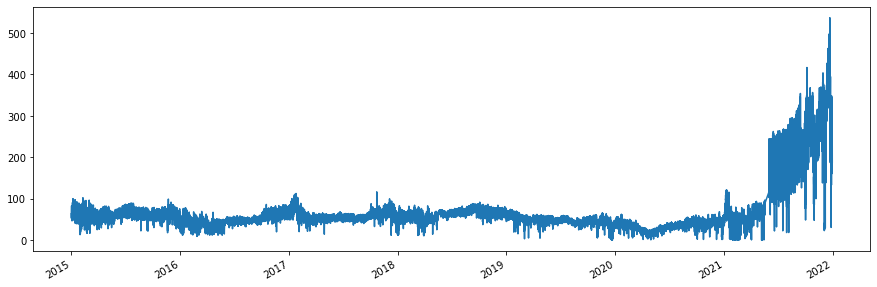

In [42]:
df['price tomorrow'].plot(figsize=(15,5));

## Use price day ahead col, predict each year

## Predict 2015

In [48]:
# Split data and target
X_train = df.loc['2016':].drop(columns=['price tomorrow'])
X_test  = df.loc['2015'].drop(columns=['price tomorrow'])

y_train = df.loc['2016':,'price tomorrow']
y_test = df.loc['2015', 'price tomorrow']

rf_13 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9922764513685587
r2_test:  0.2880375468234349


## Predict 2016

In [49]:
# Split data and target
X_train = df.loc['2015' and '2017':].drop(columns=['price tomorrow'])
X_test  = df.loc['2016'].drop(columns=['price tomorrow'])

y_train = df.loc['2015' and '2017':,'price tomorrow']
y_test = df.loc['2016', 'price tomorrow']

rf_14 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9919359896280869
r2_test:  0.19656441079271836


## Predict 2017

In [50]:
# Split data and target
X_train = df.loc[:'2016' and '2018':].drop(columns=['price tomorrow'])
X_test  = df.loc['2017'].drop(columns=['price tomorrow'])

y_train = df.loc[:'2016' and '2018':,'price tomorrow']
y_test = df.loc['2017', 'price tomorrow']

rf_15 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9829974278635967
r2_test:  0.9808768370678527


## Predict 2018

In [51]:
# Split data and target
X_train = df.loc[:'2017' and '2019':].drop(columns=['price tomorrow'])
X_test  = df.loc['2018'].drop(columns=['price tomorrow'])

y_train = df.loc[:'2017' and '2019':,'price tomorrow']
y_test = df.loc['2018', 'price tomorrow']

rf_16 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.984359864718261
r2_test:  0.979574528605462


## Predict 2019

In [52]:
# Split data and target
X_train = df.loc[:'2018' and '2020':].drop(columns=['price tomorrow'])
X_test  = df.loc['2019'].drop(columns=['price tomorrow'])

y_train = df.loc[:'2018' and '2020':,'price tomorrow']
y_test = df.loc['2019', 'price tomorrow']

rf_17 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9872762249215412
r2_test:  0.9782476744891457


## Predict 2020

In [53]:
# Split data and target
X_train = df.loc[:'2019' and '2021':].drop(columns=['price tomorrow'])
X_test  = df.loc['2020'].drop(columns=['price tomorrow'])

y_train = df.loc[:'2019' and '2021':,'price tomorrow']
y_test = df.loc['2020', 'price tomorrow']

rf_18 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9919496386666498
r2_test:  0.9632457054305507


## Predict 2021

In [54]:
# Split data and target
X_train = df.loc[:'2020'].drop(columns=['price tomorrow'])
X_test  = df.loc['2021'].drop(columns=['price tomorrow'])

y_train = df.loc[:'2020':,'price tomorrow']
y_test = df.loc['2021', 'price tomorrow']

rf_19 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9872762249215412
r2_test:  0.24898734483302826


## Column Analysis Year by Year

In [89]:
year_groups = X.groupby(by = X.index.year).mean()

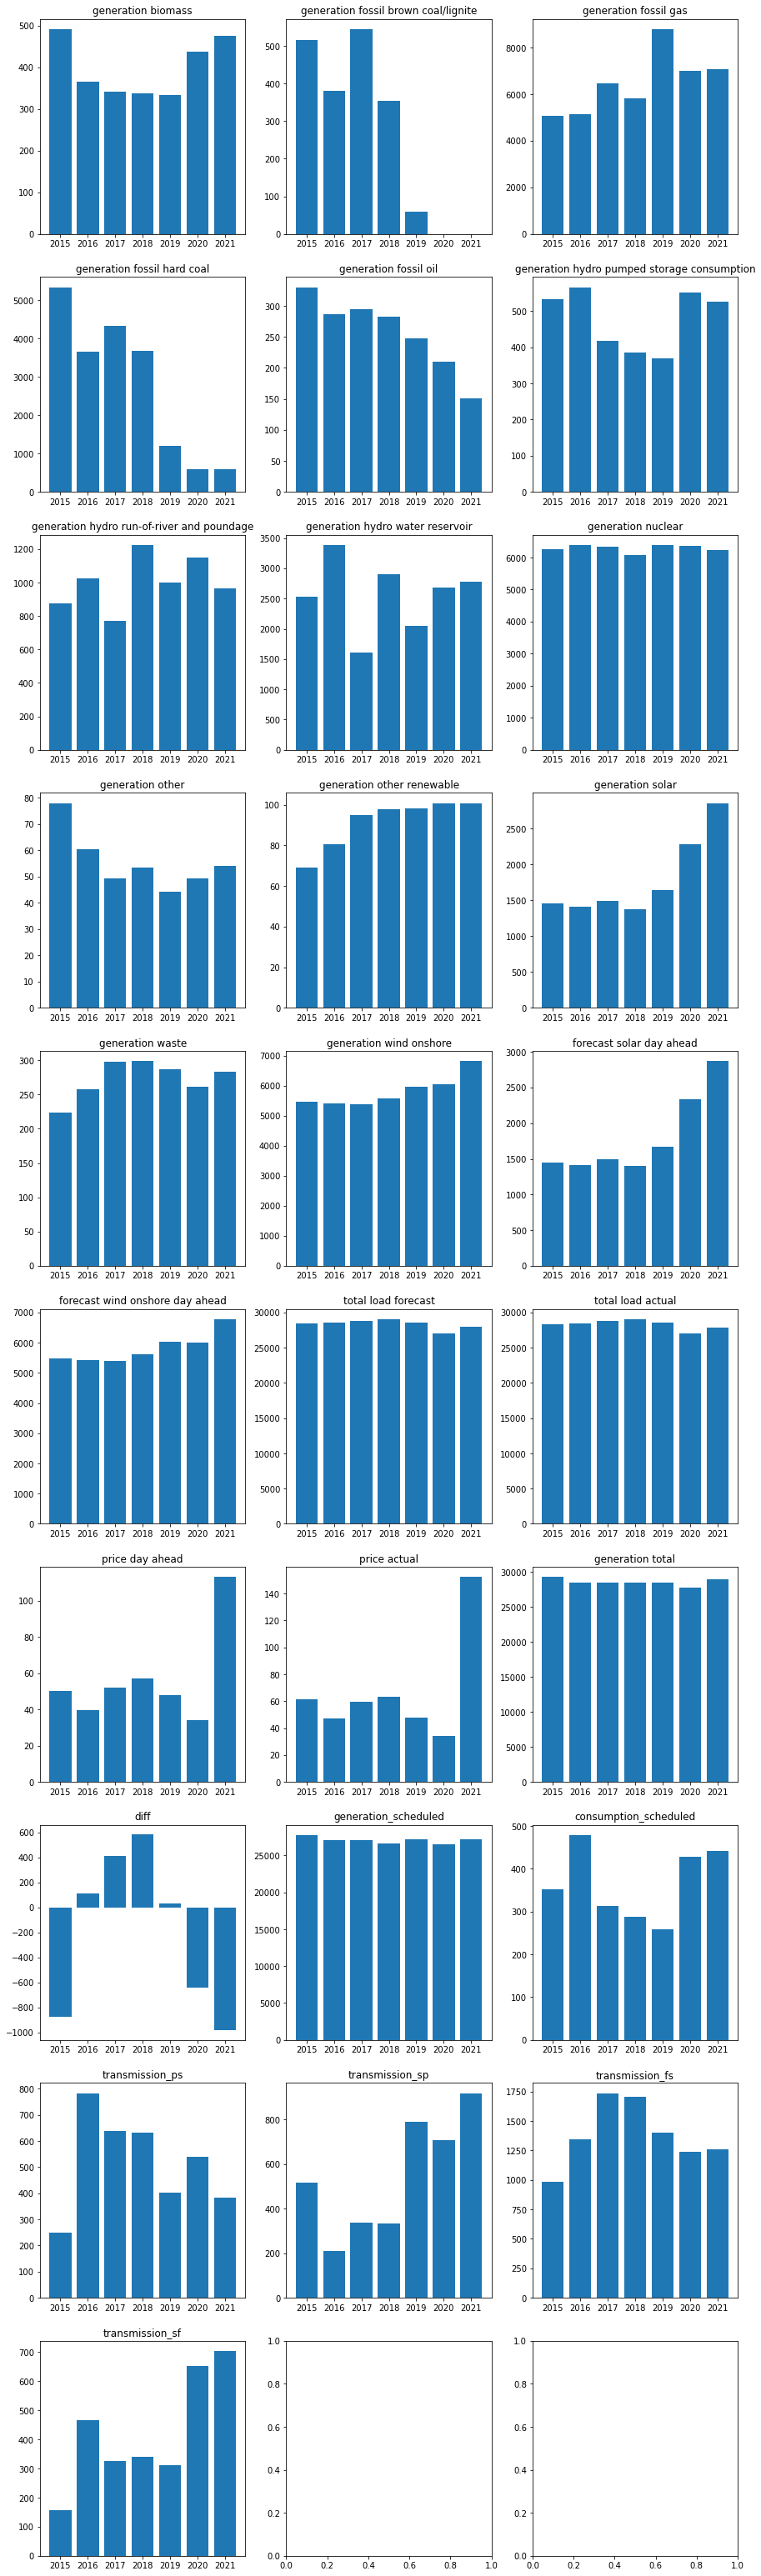

In [90]:
fig, ax = plt.subplots(nrows=len(X.columns)//3+1, ncols=3,figsize=(15, 2*len(X.columns)))
for i, col in enumerate(X.columns):
    r = i//3
    c = i%3
    ax[r][c].bar(x=year_groups.index, height = year_groups[col],);
    ax[r][c].set_title(col);

In [76]:
0//3

0

In [77]:
1//3

0

In [78]:
2//3

0

In [79]:
3//3

1

In [80]:
4//3

1

In [81]:
5//3

1

In [105]:
df[['temp_Seville',
       'pressure_Seville', 'humidity_Seville', 'wind_speed_Seville',
       'wind_deg_Seville', 'rain_1h_Seville', 'rain_3h_Seville',
       'snow_3h_Seville', 'clouds_all_Seville', 'description_Seville']]

,temp_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,rain_3h_Seville,snow_3h_Seville,clouds_all_Seville,description_Seville
2015-01-01 00:00:00,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,0.0,299.0
2015-01-01 01:00:00,273.375,1039.0,75.0,1.0,21.0,0.0,0.0,0.0,0.0,299.0
2015-01-01 02:00:00,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,299.0
2015-01-01 03:00:00,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,299.0
2015-01-01 04:00:00,274.086,1039.0,71.0,3.0,27.0,0.0,0.0,0.0,0.0,299.0
...,...,...,...,...,...,...,...,...,...,...
2021-12-30 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-30 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
df.index[0].tzinfo()

TypeError: 'NoneType' object is not callable

#### Why does splitting out the year 2018 do so poorly?

In [ ]:
rf_4 = all cols, split 2018
rf_5 = price day ahead only, split 2018
rf_6 = all cols, random split
rf_7 = price day ahead only, random split

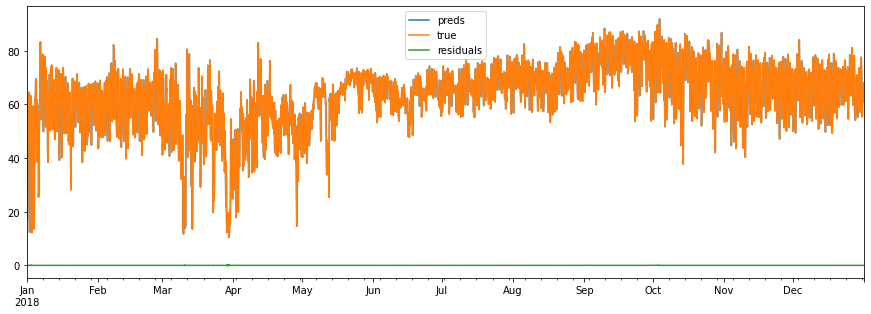

In [58]:
X_train = df_weather.loc['2015':'2017'].drop(columns='price day ahead')
X_test  = df_weather.loc['2018'].drop(columns='price day ahead')

y_train = df_weather.loc['2015':'2017','price tomorrow']
y_test = df_weather.loc['2018','price tomorrow']

start = dt.datetime(2018, 1, 1)
stop = dt.datetime(2018, 12, 31, 23)
rf4_results = pd.DataFrame({'preds':rf_4.predict(X_test), 
                            'true':y_test}, 
                           index=pd.date_range(start, stop, freq='H')
                           )
rf4_results['residuals'] = rf4_results.true - rf4_results.preds
rf4_results.plot(figsize=(15,5));

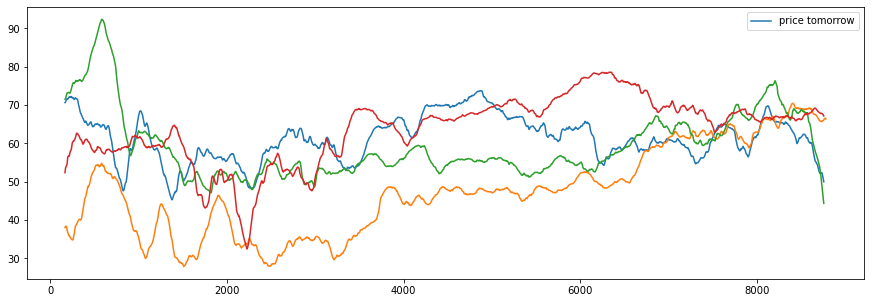

In [59]:
df_weather['price tomorrow'].loc['2015'].reset_index()['price tomorrow'].rolling(window=168).mean().plot(figsize=(15,5))
df_weather['price tomorrow'].loc['2016'].reset_index()['price tomorrow'].rolling(window=168).mean().plot(figsize=(15,5))
df_weather['price tomorrow'].loc['2017'].reset_index()['price tomorrow'].rolling(window=168).mean().plot(figsize=(15,5), legend=True)
df_weather['price tomorrow'].loc['2018'].reset_index()['price tomorrow'].rolling(window=168).mean().plot(figsize=(15,5));

In [60]:
results = pd.DataFrame({'features':X_train.columns, 'importance':rf_4.feature_importances_})
results.sort_values(by='importance', ascending=False).head(20)

,features,importance
76,price tomorrow,9.999897e-01
19,diff,1.103654e-06
11,generation solar,9.665699e-07
15,forecast wind onshore day ahead,5.427651e-07
53,wind_speed_Madrid,4.098092e-07
9,generation other,3.987496e-07
70,generation_scheduled,3.797870e-07
4,generation fossil oil,3.694020e-07
75,transmission_sf,3.253684e-07
60,temp_Valencia,2.851397e-07


In [61]:
resid_2015 = df_weather.loc['2015', 'price day ahead'] - df_weather.loc['2015', 'price tomorrow']
resid_2016 = df_weather.loc['2016', 'price day ahead'] - df_weather.loc['2016', 'price tomorrow']
resid_2017 = df_weather.loc['2017', 'price day ahead'] - df_weather.loc['2017', 'price tomorrow']
resid_2018 = df_weather.loc['2018', 'price day ahead'] - df_weather.loc['2018', 'price tomorrow']
print(resid_2015.mean())
print(resid_2016.mean())
print(resid_2017.mean())
print(resid_2018.mean())

-10.978213470319584
-7.8245286885245875
-6.9789440639269325
-6.261739726027396


In [63]:
(df_weather.corr()>.5).sum().sort_values(ascending=False).head(20)

generation fossil gas                   6
total load forecast                     6
temp_Seville                            5
temp_ Barcelona                         5
price day ahead                         5
total load actual                       5
temp_Valencia                           5
temp_Madrid                             5
temp_Bilbao                             5
generation fossil brown coal/lignite    4
generation fossil hard coal             4
generation total                        4
generation_scheduled                    4
humidity_ Barcelona                     2
generation biomass                      2
humidity_Seville                        2
humidity_Madrid                         2
pressure_Valencia                       2
humidity_Valencia                       2
consumption_scheduled                   2
dtype: int64

In [64]:
df_weather.corr()['generation fossil gas'].sort_values(ascending=False).head(10)

generation fossil gas                   1.000000
price day ahead                         0.640941
total load actual                       0.549000
total load forecast                     0.543792
generation fossil hard coal             0.542379
generation fossil brown coal/lignite    0.500410
generation total                        0.454143
generation_scheduled                    0.453185
price tomorrow                          0.376294
generation other renewable              0.336596
Name: generation fossil gas, dtype: float64

In [65]:
df_weather.corr()['temp_ Barcelona'].sort_values(ascending=False).head(10)

temp_ Barcelona             1.000000
temp_Valencia               0.917515
temp_Madrid                 0.903999
temp_Bilbao                 0.866736
temp_Seville                0.841916
forecast solar day ahead    0.391631
generation solar            0.386561
wind_deg_Seville            0.208402
diff                        0.191430
total load actual           0.167296
Name: temp_ Barcelona, dtype: float64

In [66]:
df_weather.corr()['price day ahead'].sort_values(ascending=False).head(10)

price day ahead                         1.000000
generation fossil hard coal             0.672286
generation fossil gas                   0.640941
price tomorrow                          0.623742
generation fossil brown coal/lignite    0.568483
total load forecast                     0.474786
total load actual                       0.474458
diff                                    0.434762
generation other renewable              0.429283
generation waste                        0.369069
Name: price day ahead, dtype: float64

#### Each year to predict the others 2015, 2016, 2017

# Random Forrest without Weather

In [19]:
X = df.loc[:,:'diff'].join(df.loc[:,'generation_scheduled':'transmission_sf'])
y = df.loc[:,'price tomorrow']

## Predict 2021

In [102]:
# Split data and target
X_train = X.loc[:'2020', :].drop(columns='price day ahead')
X_test  = X.loc['2021', :].drop(columns='price day ahead')

y_train = y.loc[:'2020']
y_test = y.loc['2021']

rf_10 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9853288966135381
r2_test:  0.4983591917811668


In [104]:
# Split data and target
X_train = X.loc[:'2020', :]
X_test  = X.loc['2021', :]

y_train = y.loc[:'2020']
y_test = y.loc['2021']

rf_11 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9853484739851249
r2_test:  0.4942581451735512


## Predict 2020

In [24]:
# Split data and target
X_train = X.loc[:'2019' and '2021', :].drop(columns='price day ahead')
X_test  = X.loc['2020', :].drop(columns='price day ahead')

y_train = y.loc[:'2019' and '2021']
y_test = y.loc['2020']

rf_12 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9944753380447451
r2_test:  0.9774720722609893


## Predict 2019

In [25]:
# Split data and target
X_train = X.loc[:'2018' and '2020':, :].drop(columns='price day ahead')
X_test  = X.loc['2019', :].drop(columns='price day ahead')

y_train = y.loc[:'2018' and '2020':]
y_test = y.loc['2019']

rf_13 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9853288966135381
r2_test:  0.9749246631590144


## Predict 2018

In [26]:
# Split data and target
X_train = X.loc[:'2017' and '2019':, :].drop(columns='price day ahead')
X_test  = X.loc['2018', :].drop(columns='price day ahead')

y_train = y.loc[:'2017' and '2019':]
y_test = y.loc['2018']

rf_14 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9816302921703326
r2_test:  0.9764677544021004


## Predict 2017

In [27]:
# Split data and target
X_train = X.loc[:'2016' and '2018':, :].drop(columns='price day ahead')
X_test  = X.loc['2017', :].drop(columns='price day ahead')

y_train = y.loc[:'2016' and '2018':]
y_test = y.loc['2017']

rf_15 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9809083973692719
r2_test:  0.977967200467218


## Predict 2016

In [30]:
# Split data and target
X_train = X.loc['2015' and '2017':, :].drop(columns='price day ahead')
X_test  = X.loc['2016', :].drop(columns='price day ahead')

y_train = y.loc['2015' and '2017':]
y_test = y.loc['2016']

rf_16 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9945918744515214
r2_test:  0.4045800039049617


## Predict 2015

In [31]:
# Split data and target
X_train = X.loc['2016':, :].drop(columns='price day ahead')
X_test  = X.loc['2015', :].drop(columns='price day ahead')

y_train = y.loc['2016':]
y_test = y.loc['2015']

rf_17 = fit_train(X_train, X_test, y_train, y_test)

r2_train:  0.9946828110723812
r2_test:  0.4409270058229859
